In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split

from torchsummary import summary
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

import time

import random

import copy

import sklearn.metrics as skm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def data_generator(path, target_size=(224, 224), augmentation=False, augmentation_factor=1):

    image_list = []

    base_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x[:3,:,:])
    ])

    # Veri artırma dönüşümleri
    augmentation_transforms = [
        # Orijinal görüntü için baz dönüşüm
        base_transform,

        # Yatay döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Parlaklık ve kontrast ayarları
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif zoom
        transforms.Compose([
            transforms.Resize((int(target_size[0]*1.1), int(target_size[1]*1.1))),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif bulanıklaştırma
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ])
    ]

    image_files = sorted(os.listdir(path))

    for image_name in image_files:
        image_path = os.path.join(path, image_name)

        img = Image.open(image_path)

        # Orijinal görüntüyü ekle
        img_tensor = base_transform(img)
        image_list.append(img_tensor)

        # Eğer veri artırma isteniyorsa
        if augmentation:
            # Kaç tane dönüşüm uygulayacağımızı belirle (augmentation_factor kadar)
            num_transforms = min(augmentation_factor, len(augmentation_transforms)-1)

            # Dönüşümleri rastgele seç (ilk dönüşüm orijinal görüntü olduğu için 1'den başla)
            chosen_transforms = random.sample(range(1, len(augmentation_transforms)), num_transforms)

            for transform_idx in chosen_transforms:
                transform = augmentation_transforms[transform_idx]
                augmented_tensor = transform(img)
                image_list.append(augmented_tensor)

    data = torch.stack(image_list)
    return data

In [5]:
# No stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmesiz"

print("Images are loading...")
NS_images = data_generator(folder_path, augmentation=False)

print(f"Total images: {NS_images.shape[0]}")
print(f"Shapes: {NS_images[0].shape}")

Images are loading...
Total images: 4427
Shapes: torch.Size([3, 224, 224])


In [6]:
# Stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmeli"

print("Images are loading...")
S_images = data_generator(folder_path, augmentation=True, augmentation_factor=1)

print(f"Total stroke images: {S_images.shape[0]}")
print(f"Stroke images shape: {S_images[0].shape}")

Images are loading...
Total stroke images: 4446
Stroke images shape: torch.Size([3, 224, 224])


In [7]:
# Test images

folder_path_NS = "/content/drive/My Drive/veriler/test/inmesiz"
folder_path_S = "/content/drive/My Drive/veriler/test/inmeli"

print("Images are loading...")
NS_test_images = data_generator(folder_path_NS)
S_test_images = data_generator(folder_path_S)

print(f"Total no stroke test images: {NS_test_images.shape[0]}")
print(f"No stroke test images shape: {NS_test_images[0].shape}")

print(f"Total stroke test images: {S_test_images.shape[0]}")
print(f"Stroke test images shape: {S_test_images[0].shape}")

Images are loading...
Total no stroke test images: 130
No stroke test images shape: torch.Size([3, 224, 224])
Total stroke test images: 167
Stroke test images shape: torch.Size([3, 224, 224])


In [8]:
# External test images

folder_path_external_NS = "/content/drive/My Drive/veriler/test/baska_test/inmesiz"
folder_path_external_S = "/content/drive/My Drive/veriler/test/baska_test/b_stroke"

print("Images are loading...")
external_NS_images = data_generator(folder_path_external_NS)
external_NS_images = external_NS_images[:192]
external_S_images = data_generator(folder_path_external_S)

print(f"Total external test no stroke images: {external_NS_images.shape[0]}")
print(f"External test no stroke images shape: {external_NS_images[0].shape}")

print(f"Total external test stroke images: {external_S_images.shape[0]}")
print(f"External test stroke images shape: {external_S_images[0].shape}")

Images are loading...
Total external test no stroke images: 192
External test no stroke images shape: torch.Size([3, 224, 224])
Total external test stroke images: 192
External test stroke images shape: torch.Size([3, 224, 224])


In [9]:
# Combine the images

train_val_data = torch.cat((NS_images, S_images), dim=0)
train_val_labels = torch.cat((torch.zeros(NS_images.shape[0]), torch.ones(S_images.shape[0])), dim=0)
train_val_labels = train_val_labels[:,None]

test_data = torch.cat((NS_test_images, S_test_images), dim=0)
test_labels = torch.cat((torch.zeros(NS_test_images.shape[0]), torch.ones(S_test_images.shape[0])), dim=0)
test_labels = test_labels[:,None]

external_data = torch.cat((external_NS_images, external_S_images), dim=0)
external_labels = torch.cat(
    (
        torch.zeros(external_NS_images.shape[0]),
        torch.ones(external_S_images.shape[0])
    ),
    dim=0
)
external_labels = external_labels[:,None]

print(f"Train/val data shape: {train_val_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"External test data shape: {external_data.shape}")
print("--------------------------------")
print(f"Train/val labels shape: {train_val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"External test labels shape: {external_labels.shape}")
print("--------------------------------")
print(f"What is the label? (train/val) {train_val_labels[NS_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (test) {test_labels[NS_test_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (external) {external_labels[external_NS_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (train/val) {train_val_labels[NS_images.shape[0]]}") # Has to be 1
print(f"What is the label? (test) {test_labels[NS_test_images.shape[0]]}") # Has to be 1
print(f"What is the label? (external) {external_labels[external_NS_images.shape[0]]}") # Has to be 1

Train/val data shape: torch.Size([8873, 3, 224, 224])
Test data shape: torch.Size([297, 3, 224, 224])
External test data shape: torch.Size([384, 3, 224, 224])
--------------------------------
Train/val labels shape: torch.Size([8873, 1])
Test labels shape: torch.Size([297, 1])
External test labels shape: torch.Size([384, 1])
--------------------------------
What is the label? (train/val) tensor([0.])
What is the label? (test) tensor([0.])
What is the label? (external) tensor([0.])
What is the label? (train/val) tensor([1.])
What is the label? (test) tensor([1.])
What is the label? (external) tensor([1.])


In [10]:
# Split the data into train and dev

train_data, dev_data, train_labels, dev_labels = train_test_split(
    train_val_data,
    train_val_labels,
    test_size=0.2
)

print(f"Train data shape: {train_data.shape}")
print(f"Dev data shape: {dev_data.shape}")
print("--------------------------------")
print(f"Train labels shape: {train_labels.shape}")
print(f"Dev labels shape: {dev_labels.shape}")

Train data shape: torch.Size([7098, 3, 224, 224])
Dev data shape: torch.Size([1775, 3, 224, 224])
--------------------------------
Train labels shape: torch.Size([7098, 1])
Dev labels shape: torch.Size([1775, 1])


In [11]:
# Create the datasets

train_dataset = TensorDataset(train_data, train_labels)
dev_dataset = TensorDataset(dev_data, dev_labels)
test_dataset = TensorDataset(test_data, test_labels)
external_dataset = TensorDataset(external_data, external_labels)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])
external_loader = DataLoader(external_dataset, batch_size=external_dataset.tensors[0].shape[0])

print(f"Train loader: {train_loader.dataset[0][0].shape}")
print(f"Dev loader: {dev_loader.dataset[0][0].shape}")
print(f"Test loader: {test_loader.dataset[0][0].shape}")
print(f"External test loader: {external_loader.dataset[0][0].shape}")

Train loader: torch.Size([3, 224, 224])
Dev loader: torch.Size([3, 224, 224])
Test loader: torch.Size([3, 224, 224])
External test loader: torch.Size([3, 224, 224])


In [12]:
from torchvision import models

def pretrained():
    # Load the model
    model = models.vit_b_32(weights=models.ViT_B_32_Weights.IMAGENET1K_V1)

    # First, freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Sadece heads kısmını eğitilebilir bırak
    for name, param in model.named_parameters():
        if "heads" in name:
            param.requires_grad = True

    # ViT modelinde in_features'ı bulma
    num_features = model.heads.head.in_features

    # Simple FC structure
    model.heads = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(32, 1)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    return model, optimizer, loss_fn

In [13]:
net, optimizer, lossfunc = pretrained()

X, y = next(iter(train_loader))

yHat = net(X)

loss = lossfunc(yHat, y)

print(f"Loss: {loss.item()}")

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:01<00:00, 223MB/s]


Loss: 0.6975203156471252


In [14]:
pip install torchinfo

In [15]:
from torchinfo import summary

summary(net, (1, 3, 224, 224), device="cpu")

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 1]                    768
├─Conv2d: 1-1                                 [1, 768, 7, 7]            (2,360,064)
├─Encoder: 1-2                                [1, 50, 768]              38,400
│    └─Dropout: 2-1                           [1, 50, 768]              --
│    └─Sequential: 2-2                        [1, 50, 768]              --
│    │    └─EncoderBlock: 3-1                 [1, 50, 768]              (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 50, 768]              (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 50, 768]              (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 50, 768]              (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 50, 768]              (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 50, 768]              (7,087,872)
│    │    └─EncoderBlock: 3

In [16]:

# def func2TrainMedrixNet(printtoggle=True):

#     timerInFunction = time.process_time()

#     numepochs = 100

#     # Early stopping parametreleri
#     patience = 15
#     best_val_acc = 0.0
#     counter = 0
#     best_model = None

#     net, optimizer, lossfunc = pretrained()

#     net.to(device)

#     trainAcc = torch.zeros(numepochs)
#     trainLoss = torch.zeros(numepochs)
#     devAcc = torch.zeros(numepochs)
#     devLoss = torch.zeros(numepochs)

#     for epoch in range(numepochs):

#         net.train()

#         batchAcc = []
#         batchLoss = []

#         for X, y in train_loader:

#             y = y.unsqueeze(1)

#             X = X.to(device)
#             y = y.to(device)

#             yHat = net(X)
#             loss = lossfunc(yHat, y)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             batchLoss.append(loss.item())
#             batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

#         trainLoss[epoch] = np.mean(batchLoss)
#         trainAcc[epoch] = 100*np.mean(batchAcc)

#         net.eval()

#         batchAcc = []
#         batchLoss = []

#         for X, y in dev_loader:

#             y = y.unsqueeze(1)

#             X = X.to(device)
#             y = y.to(device)

#             with torch.no_grad():
#                 yHat = net(X)
#                 loss = lossfunc(yHat, y)

#             batchLoss.append(loss.item())
#             batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

#         current_val_loss = np.mean(batchLoss)
#         current_val_acc = 100*np.mean(batchAcc)

#         devLoss[epoch] = current_val_loss
#         devAcc[epoch] = current_val_acc

#         comptime = time.process_time() - timerInFunction

#         if printtoggle:
#             print(f'Epoch {epoch+1}/{numepochs} | Computing time: {comptime:.0f} sec | Train Accuracy: {trainAcc[epoch]:.2f}% | Validation Accuracy: {devAcc[epoch]:.2f}%')

#         # Early stopping control
#         if current_val_acc > best_val_acc:
#             best_val_acc = current_val_acc
#             counter = 0
#             # Save the best model
#             best_model = copy.deepcopy(net.state_dict())

#             if printtoggle:
#                 print(f"The validation accuracy saved! The best validation accuracy is: {best_val_acc:.2f}%")
#                 print("")
#         else:
#             counter += 1
#             if printtoggle:
#                 print(f"Early stopping counter: {counter}/{patience}")
#                 print("")

#             if counter >= patience:
#                 if printtoggle:
#                     print(f"Early stopping! With epoch {epoch+1} training stopped.")
#                 # Load the best model
#                 net.load_state_dict(best_model)
#                 break

#     # If early stopping is not triggered, load the best model
#     if best_model is not None and epoch == numepochs - 1:
#         net.load_state_dict(best_model)
#         if printtoggle:
#             print("Training finished, the best model is loaded.")

#     return trainAcc[:epoch+1], trainLoss[:epoch+1], devAcc[:epoch+1], devLoss[:epoch+1], net

In [17]:
# trainAcc, trainLoss, devAcc, devLoss, net = func2TrainMedrixNet()

In [18]:
# # Save the model

# torch.save(net.state_dict(), "vitB32.pth")

In [19]:
# Load the model

the_path = "drive/My Drive/model_weights/vitB32.pth"
net, _, _ = pretrained()
net.load_state_dict(torch.load(the_path))
net.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [20]:
# Test the model

net.eval()

X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
    yHat = net(X)
    loss = lossfunc(yHat, y)

testLoss = loss.item()
testAcc = 100*torch.mean( ( (yHat>0) == y ).float() ).item()

print(f"Test Loss: {testLoss:.4f}")
print(f"Test Accuracy: {testAcc:.2f}%")

Test Loss: 0.7042
Test Accuracy: 75.42%


In [21]:

# External results

net.eval()

batchAcc = []
batchLoss = []

for X, y in external_loader:

    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
        yHat = net(X)
        loss = lossfunc(yHat, y)

    batchLoss.append(loss.item())
    batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

externalLoss = np.mean(batchLoss)
externalAcc = 100*np.mean(batchAcc)

print(f"External Loss: {externalLoss:.4f}")
print(f"External Accuracy: {externalAcc:.3f}%")

External Loss: 0.7711
External Accuracy: 77.865%


In [22]:
# # Plot the accuracy and loss

# fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# ax[0].plot(trainAcc,"s-", label='Training Accuracy')
# ax[0].plot(devAcc,"o-", label='Validation Accuracy')
# ax[0].plot(trainAcc.shape[0]-1,testAcc,"r*",markersize=15, label='Test Accuracy')
# ax[0].plot(trainAcc.shape[0]-1,externalAcc,"g*",markersize=15, label='External Test Accuracy')
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_title(f'Training, Validation, Test And External Accuracy: {trainAcc[-1]:.2f}% | {devAcc[-1]:.2f}% | {testAcc:.2f}% | {externalAcc:.2f}%')
# ax[0].grid()
# ax[0].legend()

# ax[1].plot(trainLoss,"s-", label='Training Loss')
# ax[1].plot(devLoss,"o-", label='Validation Loss')
# ax[1].plot(trainLoss.shape[0]-1,testLoss,"r*",markersize=15, label='Test Loss')
# ax[1].plot(trainLoss.shape[0]-1,externalLoss,"g*",markersize=15, label='External Test Loss')
# ax[1].set_xlabel('Epoch')
# ax[1].set_ylabel('Loss')
# ax[1].set_title(f'Training, Validation, Test And External Loss: {trainLoss[-1]:.4f} | {devLoss[-1]:.4f} | {testLoss:.4f} | {externalLoss:.4f}')
# ax[1].grid()
# ax[1].legend()

# plt.show()

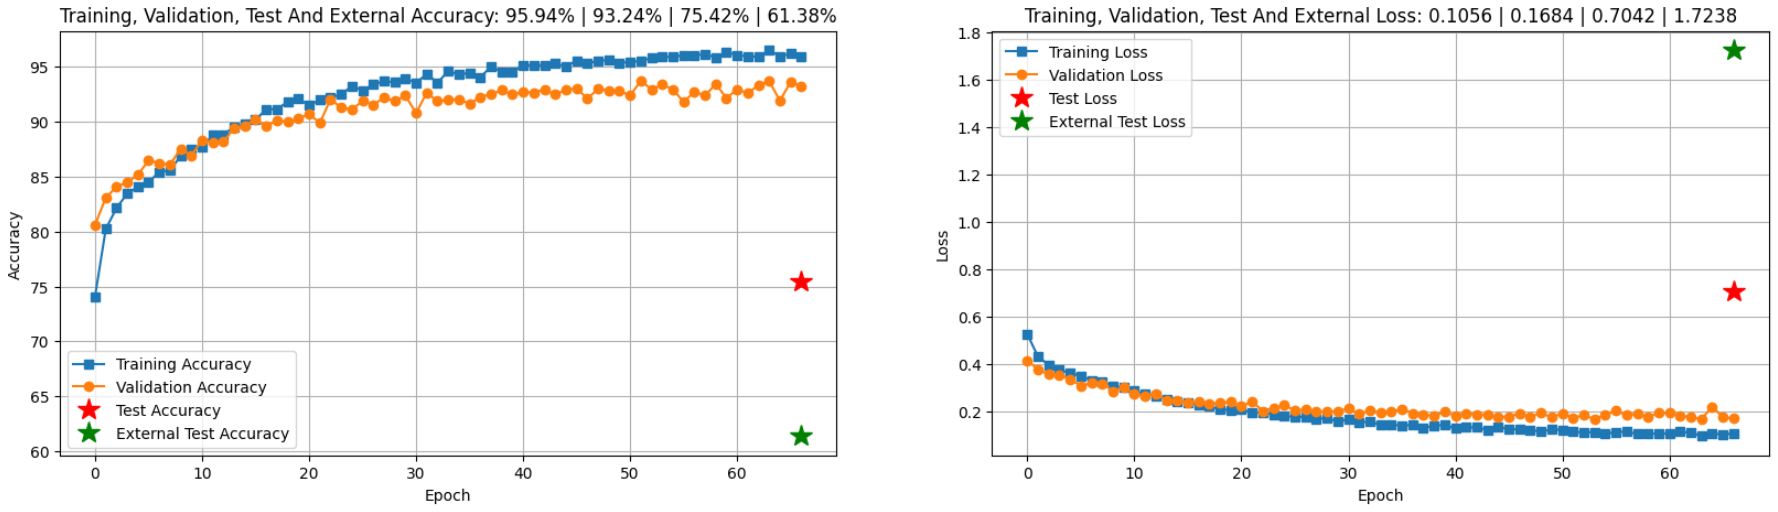

In [23]:
# Predict the model

train_predictions = []
train_actual_labels = []

for X, y in train_loader:
    X = X.to(device)
    with torch.no_grad():
        yHat = net(X)
        train_predictions.append(yHat)
        train_actual_labels.append(y)

train_predictions = torch.cat(train_predictions).cpu()
train_actual_labels = torch.cat(train_actual_labels).cpu()

dev_predictions = []
dev_actual_labels = []

for X, y in dev_loader:
    X = X.to(device)
    with torch.no_grad():
        yHat = net(X)
        dev_predictions.append(yHat)
        dev_actual_labels.append(y)

dev_predictions = torch.cat(dev_predictions).cpu()
dev_actual_labels = torch.cat(dev_actual_labels).cpu()

test_predictions = []
test_actual_labels = []

for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        yHat = net(X)
        test_predictions.append(yHat)
        test_actual_labels.append(y)

test_predictions = torch.cat(test_predictions).cpu()
test_actual_labels = torch.cat(test_actual_labels).cpu()

external_predictions = []
external_actual_labels = []

for X, y in external_loader:
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        yHat = net(X)
        external_predictions.append(yHat)
        external_actual_labels.append(y)

external_predictions = torch.cat(external_predictions).cpu()
external_actual_labels = torch.cat(external_actual_labels).cpu()

print(f"Train predictions shape: {train_predictions.shape}")
print(f"Train actual labels shape: {train_actual_labels.shape}")
print(f"Dev predictions shape: {dev_predictions.shape}")
print(f"Dev actual labels shape: {dev_actual_labels.shape}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test actual labels shape: {test_actual_labels.shape}")
print(f"External predictions shape: {external_predictions.shape}")
print(f"External actual labels shape: {external_actual_labels.shape}")

Train predictions shape: torch.Size([7072, 1])
Train actual labels shape: torch.Size([7072, 1])
Dev predictions shape: torch.Size([1760, 1])
Dev actual labels shape: torch.Size([1760, 1])
Test predictions shape: torch.Size([297, 1])
Test actual labels shape: torch.Size([297, 1])
External predictions shape: torch.Size([384, 1])
External actual labels shape: torch.Size([384, 1])


In [24]:
# Confusion matrices

trainConf = skm.confusion_matrix(train_actual_labels, train_predictions>0)
devConf = skm.confusion_matrix(dev_actual_labels, dev_predictions>0)
testConf = skm.confusion_matrix(test_actual_labels, test_predictions>0)
externalConf = skm.confusion_matrix(external_actual_labels, external_predictions>0)

print(f"Train confusion matrix: \n {trainConf}")
print(f"Dev confusion matrix: \n {devConf}")
print(f"Test confusion matrix: \n {testConf}")
print(f"External confusion matrix: \n {externalConf}")

Train confusion matrix: 
 [[3496   40]
 [ 127 3409]]
Dev confusion matrix: 
 [[862  10]
 [ 38 850]]
Test confusion matrix: 
 [[112  18]
 [ 55 112]]
External confusion matrix: 
 [[184   8]
 [ 77 115]]


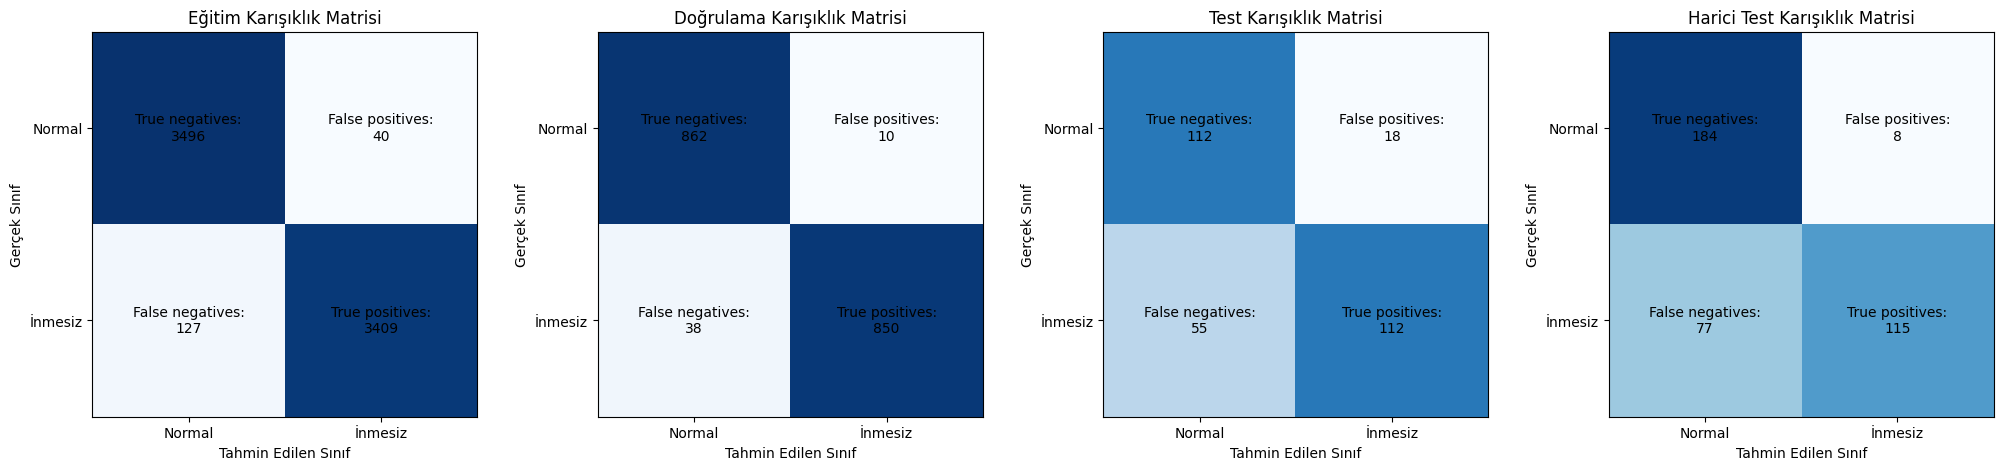

In [25]:
# Confusion Matrices

fig,ax = plt.subplots(1,4,figsize=(25,5))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['Normal','İnmesiz'])
ax[0].set_yticklabels(['Normal','İnmesiz'])
ax[0].set_xlabel('Tahmin Edilen Sınıf')
ax[0].set_ylabel('Gerçek Sınıf')
ax[0].set_title('Eğitim Karışıklık Matrisi')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]}',ha='center',va='center')

# confmat during DEV
ax[1].imshow(devConf,'Blues',vmax=len(dev_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['Normal','İnmesiz'])
ax[1].set_yticklabels(['Normal','İnmesiz'])
ax[1].set_xlabel('Tahmin Edilen Sınıf')
ax[1].set_ylabel('Gerçek Sınıf')
ax[1].set_title('Doğrulama Karışıklık Matrisi')

# add text labels
ax[1].text(0,0,f'True negatives:\n{devConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{devConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{devConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{devConf[0,1]}',ha='center',va='center')

# confmat during TEST
ax[2].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[2].set_xticks([0,1])
ax[2].set_yticks([0,1])
ax[2].set_xticklabels(['Normal','İnmesiz'])
ax[2].set_yticklabels(['Normal','İnmesiz'])
ax[2].set_xlabel('Tahmin Edilen Sınıf')
ax[2].set_ylabel('Gerçek Sınıf')
ax[2].set_title('Test Karışıklık Matrisi')

# add text labels
ax[2].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[2].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[2].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[2].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')

# confmat during EXTERNAL
ax[3].imshow(externalConf,'Blues',vmax=len(external_predictions)/2)
ax[3].set_xticks([0,1])
ax[3].set_yticks([0,1])
ax[3].set_xticklabels(['Normal','İnmesiz'])
ax[3].set_yticklabels(['Normal','İnmesiz'])
ax[3].set_xlabel('Tahmin Edilen Sınıf')
ax[3].set_ylabel('Gerçek Sınıf')
ax[3].set_title('Harici Test Karışıklık Matrisi')

# add text labels
ax[3].text(0,0,f'True negatives:\n{externalConf[0,0]}' ,ha='center',va='center')
ax[3].text(0,1,f'False negatives:\n{externalConf[1,0]}',ha='center',va='center')
ax[3].text(1,1,f'True positives:\n{externalConf[1,1]}' ,ha='center',va='center')
ax[3].text(1,0,f'False positives:\n{externalConf[0,1]}',ha='center',va='center')

plt.show()

In [26]:

# Test & External Metrics

test_Acc = skm.accuracy_score(test_actual_labels, test_predictions>0)
test_Prec = skm.precision_score(test_actual_labels, test_predictions>0)
test_Rec = skm.recall_score(test_actual_labels, test_predictions>0)
test_F1 = skm.f1_score(test_actual_labels, test_predictions>0)

external_Acc = skm.accuracy_score(external_actual_labels, external_predictions>0)
external_Prec = skm.precision_score(external_actual_labels, external_predictions>0)
external_Rec = skm.recall_score(external_actual_labels, external_predictions>0)
external_F1 = skm.f1_score(external_actual_labels, external_predictions>0)

print("--------------- Test Metrics ---------------")
print(f"Test Accuracy: {test_Acc:.3f}")
print(f"Test Precision: {test_Prec:.3f}")
print(f"Test Recall: {test_Rec:.3f}")
print(f"Test F1 Score: {test_F1:.3f}")

print("--------------- External Metrics ---------------")
print(f"External Accuracy: {external_Acc:.3f}")
print(f"External Precision: {external_Prec:.3f}")
print(f"External Recall: {external_Rec:.3f}")
print(f"External F1 Score: {external_F1:.3f}")

--------------- Test Metrics ---------------
Test Accuracy: 0.754
Test Precision: 0.862
Test Recall: 0.671
Test F1 Score: 0.754
--------------- External Metrics ---------------
External Accuracy: 0.779
External Precision: 0.935
External Recall: 0.599
External F1 Score: 0.730


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.calibration import calibration_curve
import seaborn as sns

class BinaryConfidenceAnalysis:
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def get_predictions(self):
        """Get predictions and probabilities from test data"""
        y_true = []
        y_pred = []
        y_probs = []  # Probability of positive class (class 1)

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)

                # Handle different model output formats
                if outputs.shape[1] == 1:  # Single output (sigmoid)
                    probs = torch.sigmoid(outputs).squeeze()
                    preds = (probs >= 0.5).long()
                else:  # Two outputs (softmax)
                    probs = torch.softmax(outputs, dim=1)[:, 1]
                    preds = (probs >= 0.5).long()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())

        return np.array(y_true), np.array(y_pred), np.array(y_probs)

    def bootstrap_metrics(self, n_iterations=1000, ci=95):
        """Calculate metrics with confidence intervals using bootstrap"""
        y_true, y_pred, _ = self.get_predictions()

        # Arrays to store bootstrap results
        precisions = np.zeros(n_iterations)
        recalls = np.zeros(n_iterations)
        f1_scores = np.zeros(n_iterations)

        n_samples = len(y_true)

        # Bootstrap loop
        for i in range(n_iterations):
            # Sample with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)

            # Calculate metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true[indices], y_pred[indices],
                average='binary', zero_division=0
            )

            precisions[i] = precision
            recalls[i] = recall
            f1_scores[i] = f1

        # Calculate confidence intervals
        alpha = (100 - ci) / 100 / 2
        ci_lower = alpha
        ci_upper = 1 - alpha

        results = {
            'precision': {
                'mean': np.mean(precisions),
                'ci': np.quantile(precisions, [ci_lower, ci_upper])
            },
            'recall': {
                'mean': np.mean(recalls),
                'ci': np.quantile(recalls, [ci_lower, ci_upper])
            },
            'f1': {
                'mean': np.mean(f1_scores),
                'ci': np.quantile(f1_scores, [ci_lower, ci_upper])
            }
        }

        return results

    def plot_metrics_with_ci(self):
        """Plot metrics with confidence intervals"""
        results = self.bootstrap_metrics()

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Metrics to plot
        metrics = ['precision', 'recall', 'f1']
        x_pos = np.arange(len(metrics))

        # Extract values
        means = [results[m]['mean'] for m in metrics]
        errors = [
            [results[m]['mean'] - results[m]['ci'][0] for m in metrics],
            [results[m]['ci'][1] - results[m]['mean'] for m in metrics]
        ]

        # Create bar plot with error bars
        ax.bar(x_pos, means, yerr=errors, align='center', alpha=0.7, capsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(metrics)
        ax.set_ylim(0, 1.1)
        ax.set_ylabel('Score')
        ax.set_title('Performance Metrics with 95% Confidence Intervals')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels
        for i, v in enumerate(means):
            ax.text(i, v + 0.05, f'{v:.2f}', ha='center')

        return fig

    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        y_true, y_pred, _ = self.get_predictions()

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Normalize the confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')

        return plt.gcf()

    def plot_probability_distribution(self):
        """Plot probability distribution by class"""
        y_true, _, y_probs = self.get_predictions()

        # Ensure arrays are 1D
        y_true = np.array(y_true).flatten()
        y_probs = np.array(y_probs).flatten()

        # Debug information
        print(f"Shape of y_true: {y_true.shape}")
        print(f"Shape of y_probs: {y_probs.shape}")
        print(f"Unique values in y_true: {np.unique(y_true)}")

        plt.figure(figsize=(10, 6))

        # Create mask arrays for indexing
        mask_class0 = (y_true == 0)
        mask_class1 = (y_true == 1)

        # Make sure we have samples from both classes
        if np.any(mask_class0) and np.any(mask_class1):
            # Separate probabilities by true class
            class0_probs = y_probs[mask_class0]
            class1_probs = y_probs[mask_class1]

            # Plot distributions
            sns.histplot(class0_probs, color='blue', alpha=0.5,
                         bins=20, label='True Class 0')
            sns.histplot(class1_probs, color='red', alpha=0.5,
                         bins=20, label='True Class 1')

            # Add decision threshold line
            plt.axvline(x=0.5, color='black', linestyle='--')

            plt.xlabel('Predicted Probability of Class 1')
            plt.ylabel('Count')
            plt.title('Distribution of Predicted Probabilities by True Class')
            plt.legend()
        else:
            # Handle case where only one class is present
            present_class = 1 if np.any(mask_class1) else 0
            plt.text(0.5, 0.5, f"Only class {present_class} present in dataset",
                     ha='center', va='center', fontsize=14)
            plt.title("Unable to Plot Distribution - Single Class")

        return plt.gcf()

    def plot_calibration_curve(self):
        """Plot calibration curve with confidence interval"""
        y_true, _, y_probs = self.get_predictions()

        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)

        # Calculate standard error for binomial proportion
        n_bins = len(prob_true)
        bin_total = np.bincount(np.digitize(y_probs, np.linspace(0, 1, n_bins + 1)) - 1,
                              minlength=n_bins)

        # For confidence interval
        std_err = np.sqrt(prob_true * (1 - prob_true) / np.maximum(bin_total, 1))
        ci = 1.96 * std_err  # 95% confidence interval

        # Plot
        plt.figure(figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        # Plot with confidence intervals
        plt.errorbar(prob_pred, prob_true, yerr=ci,
                    marker='o', markersize=6, linewidth=2,
                    label='Model Calibration')

        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve with 95% Confidence Interval')
        plt.legend(loc='lower right')
        plt.grid(True)

        return plt.gcf()

Shape of y_true: (297,)
Shape of y_probs: (297,)
Unique values in y_true: [0. 1.]


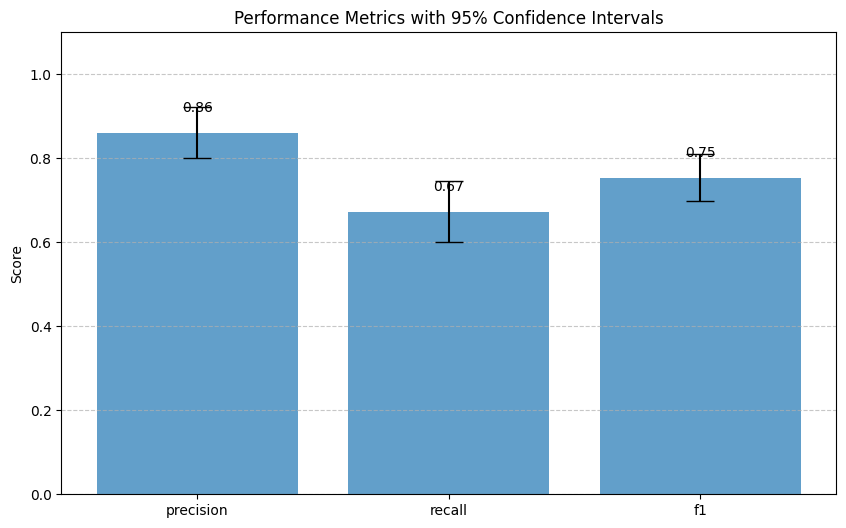

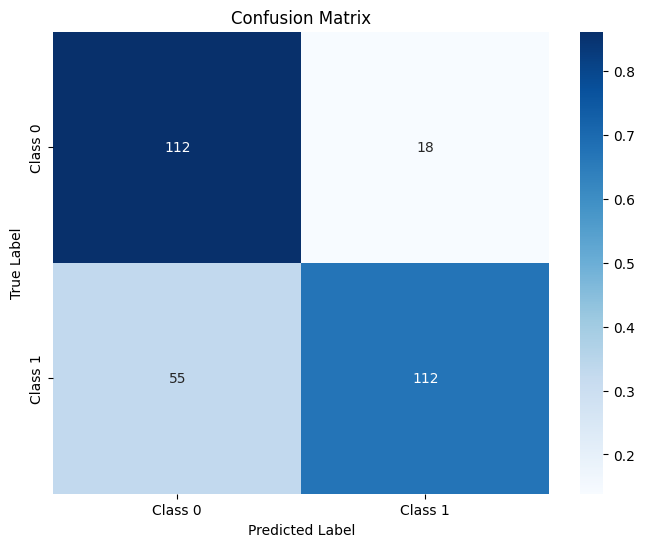

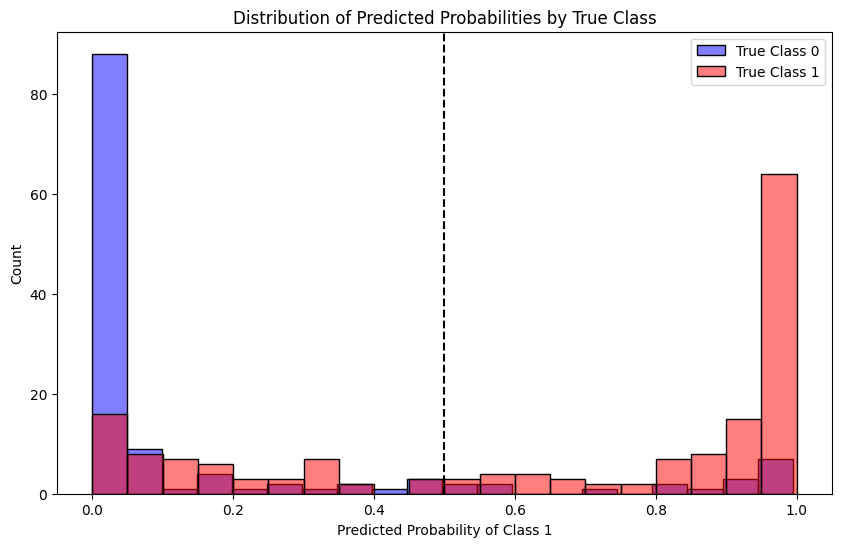

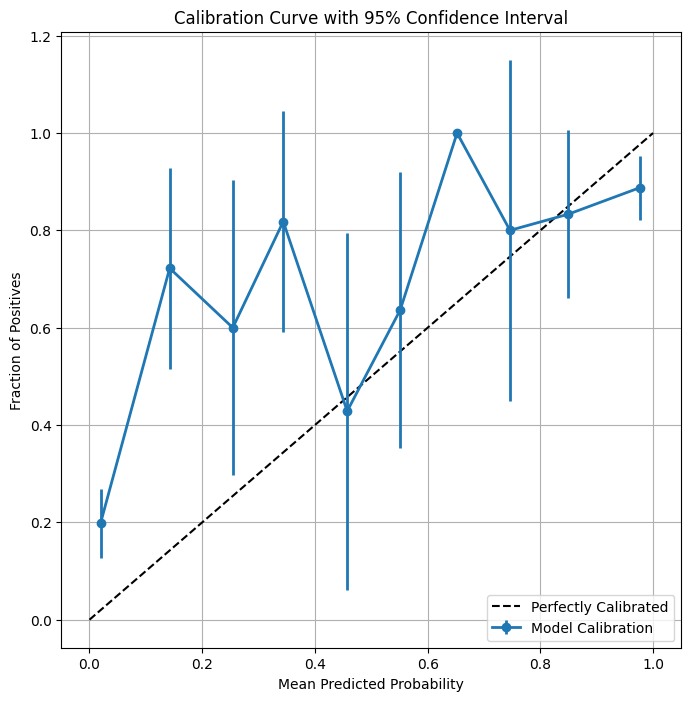

In [28]:
analyzer = BinaryConfidenceAnalysis(net, test_loader)
#
# # Visualize metrics with confidence intervals
fig1 = analyzer.plot_metrics_with_ci()
#
# # Plot confusion matrix
fig2 = analyzer.plot_confusion_matrix()
#
# # Plot probability distributions
fig3 = analyzer.plot_probability_distribution()
#
# # Plot calibration curve
fig4 = analyzer.plot_calibration_curve()
#
# # Display all plots
plt.show()